# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans


# magic word for producing visualizations in notebook
%matplotlib inline
sns.set()

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [4]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [5]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.head()

,version https://git-lfs.github.com/spec/v1
0,oid sha256:a0038eb58a7f87e8d24133913b16df8dce7...
1,size 157145280


In [6]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [7]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [8]:
#check how many nans per column
azdias.isna().sum()

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [9]:
#Get all nans from ALL columns
pre_nan = azdias.isna().sum().sum()
pre_nan

4896838

In [10]:
#parse missing_or_unknown column into list
missing_unknown = feat_info['missing_or_unknown'].apply(lambda x: x.strip('[]').split(','))

In [11]:
#Check that it's a list
type(missing_unknown[0])

list

In [12]:
#inspect dtypes 
azdias.dtypes

AGER_TYP                   int64
ALTERSKATEGORIE_GROB       int64
ANREDE_KZ                  int64
CJT_GESAMTTYP            float64
FINANZ_MINIMALIST          int64
FINANZ_SPARER              int64
FINANZ_VORSORGER           int64
FINANZ_ANLEGER             int64
FINANZ_UNAUFFAELLIGER      int64
FINANZ_HAUSBAUER           int64
FINANZTYP                  int64
GEBURTSJAHR                int64
GFK_URLAUBERTYP          float64
GREEN_AVANTGARDE           int64
HEALTH_TYP                 int64
LP_LEBENSPHASE_FEIN      float64
LP_LEBENSPHASE_GROB      float64
LP_FAMILIE_FEIN          float64
LP_FAMILIE_GROB          float64
LP_STATUS_FEIN           float64
LP_STATUS_GROB           float64
NATIONALITAET_KZ           int64
PRAEGENDE_JUGENDJAHRE      int64
RETOURTYP_BK_S           float64
SEMIO_SOZ                  int64
SEMIO_FAM                  int64
SEMIO_REL                  int64
SEMIO_MAT                  int64
SEMIO_VERT                 int64
SEMIO_LUST                 int64
          

In [13]:
#index to iterate over missing_unknown
x = 0 
for col in azdias:
    if azdias[col].dtype == 'int64' or azdias[col].dtype == 'float64':
        if missing_unknown[x] == ['']:
            azdias.loc[:,col].replace(missing_unknown[x], np.nan, inplace=True)
        else:
            azdias.loc[:,col].replace(list(map(float, missing_unknown[x])), np.nan, inplace=True)
    else:
        azdias.loc[:,col].replace(missing_unknown[x], np.nan, inplace=True)
    #print(col)
    #print(x)
    x += 1

In [14]:
#Check the number of nans after preprocessing
post_nan = azdias.isna().sum().sum()
print("Before processing: ",pre_nan)
print("After processing: ", post_nan)
print("Difference = ", post_nan-pre_nan)
azdias.head()

Before processing:  4896838
After processing:  8373929
Difference =  3477091


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [15]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
percentage = azdias.isnull().mean() * 100
percentage

AGER_TYP                 76.955435
ALTERSKATEGORIE_GROB      0.323264
ANREDE_KZ                 0.000000
CJT_GESAMTTYP             0.544646
FINANZ_MINIMALIST         0.000000
FINANZ_SPARER             0.000000
FINANZ_VORSORGER          0.000000
FINANZ_ANLEGER            0.000000
FINANZ_UNAUFFAELLIGER     0.000000
FINANZ_HAUSBAUER          0.000000
FINANZTYP                 0.000000
GEBURTSJAHR              44.020282
GFK_URLAUBERTYP           0.544646
GREEN_AVANTGARDE          0.000000
HEALTH_TYP               12.476816
LP_LEBENSPHASE_FEIN      10.954859
LP_LEBENSPHASE_GROB      10.611509
LP_FAMILIE_FEIN           8.728699
LP_FAMILIE_GROB           8.728699
LP_STATUS_FEIN            0.544646
LP_STATUS_GROB            0.544646
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
RETOURTYP_BK_S            0.544646
SEMIO_SOZ                 0.000000
SEMIO_FAM                 0.000000
SEMIO_REL                 0.000000
SEMIO_MAT                 0.000000
SEMIO_VERT          

In [16]:
percentage.describe()

count    85.000000
mean     11.054139
std      16.449815
min       0.000000
25%       0.000000
50%      10.451729
75%      13.073637
max      99.757636
dtype: float64

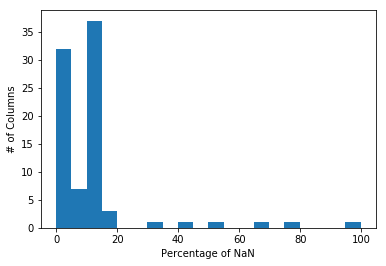

In [17]:
#Plot histogram
plt.hist(percentage, bins=20)
plt.ylabel('# of Columns')
plt.xlabel('Percentage of NaN')
plt.show()

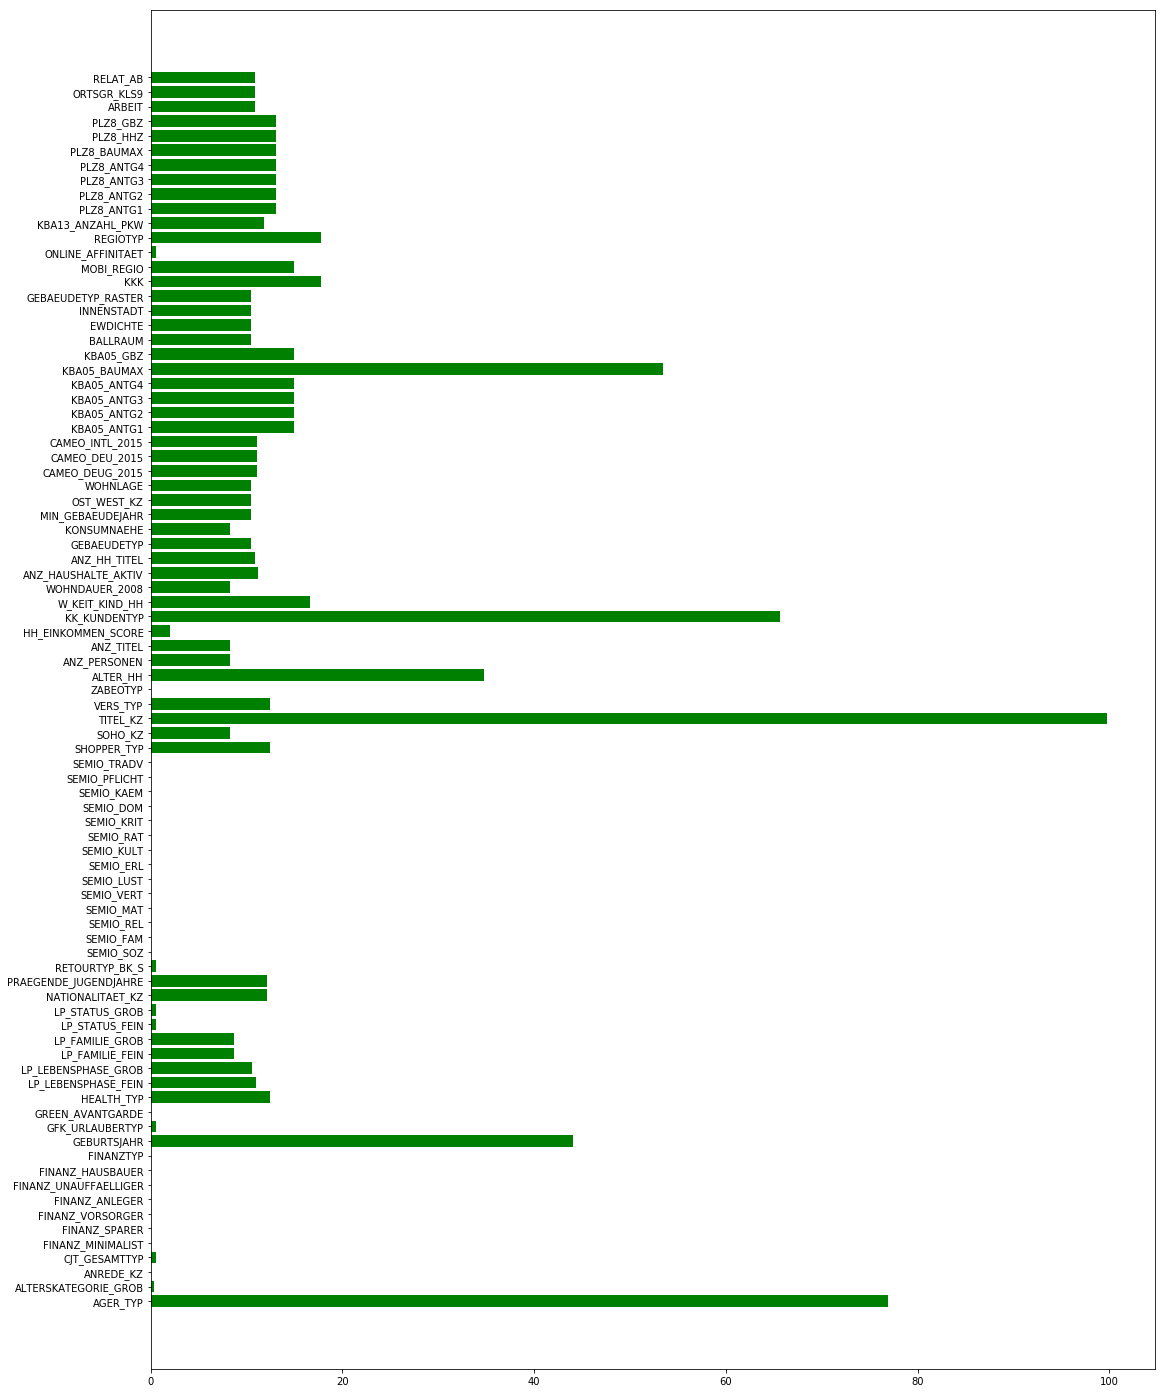

In [18]:
#Plot bar graph
x = feat_info['attribute']
y = percentage

x_pos = [i for i, _ in enumerate(x)]

plt.figure(figsize=(18,25))
plt.barh(x_pos, y, color='green')
    #plt.ylabel("Energy Source")
    #plt.xlabel("Energy Output (GJ)")

plt.yticks(x_pos, x)

plt.show()

In [19]:
# Investigate patterns in the amount of missing data in each column.
#Let's see how many are above 20%
sum(i > 20 for i in percentage)

6

In [20]:
#Which columns to drop?
to_be_dropped = []
for i in range(len(percentage)):
    if percentage[i] >= 20:
        to_be_dropped.append(feat_info.loc[i,'attribute'])
print("The columns that should be dropped are: ", to_be_dropped)

The columns that should be dropped are:  ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


In [21]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias = azdias.drop(columns=to_be_dropped)

In [22]:
print("From 85 columns in our dataframe, we went down to: ", azdias.shape[1])

From 85 columns in our dataframe, we went down to:  79


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)
#### Answer:
- The **perecentage**, histogram, and bar graph all show obvious outliers.
- These should be dropped as they would otherwise skew the clustering. 
- Best practice is to remove all those that are missing 20% or more of their data
- 6 columns have more than 20% missing data:
    - AGER_TYP
    - GEBURTSJAHR
    - TITEL_KZ
    - ALTER_HH
    - KK_KUNDENTYP
    - KBA05_BAUMAX

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [23]:
# How much data is missing in each row of the dataset?
nan_row = azdias.isna().sum(axis = 1)
nan_row.head()
nan_row.describe()

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64

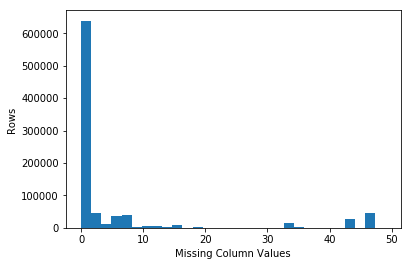

In [24]:
plt.hist(nan_row, bins=30)
plt.ylabel('Rows')
plt.xlabel('Missing Column Values')
plt.show()

In [25]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
few_missing = azdias[azdias.isnull().sum(axis=1) <= 30]
many_missing = azdias[azdias.isnull().sum(axis=1) > 30]

In [26]:
print(few_missing.shape[0])
print(many_missing.shape[0])

798067
93154


In [27]:
ratio = (many_missing.shape[0]/azdias.shape[0])*100

In [28]:
print("There are {} rows with missing data in more than 30 columns.".format(many_missing.shape[0]))
print("That's equevelant to ", round(ratio,2),"%")

There are 93154 rows with missing data in more than 30 columns.
That's equevelant to  10.45 %


In [29]:
#Columns with zero or close to zero NaN frequency
zero_columns = percentage[percentage <2]

In [30]:
zero_columns

ALTERSKATEGORIE_GROB     0.323264
ANREDE_KZ                0.000000
CJT_GESAMTTYP            0.544646
FINANZ_MINIMALIST        0.000000
FINANZ_SPARER            0.000000
FINANZ_VORSORGER         0.000000
FINANZ_ANLEGER           0.000000
FINANZ_UNAUFFAELLIGER    0.000000
FINANZ_HAUSBAUER         0.000000
FINANZTYP                0.000000
GFK_URLAUBERTYP          0.544646
GREEN_AVANTGARDE         0.000000
LP_STATUS_FEIN           0.544646
LP_STATUS_GROB           0.544646
RETOURTYP_BK_S           0.544646
SEMIO_SOZ                0.000000
SEMIO_FAM                0.000000
SEMIO_REL                0.000000
SEMIO_MAT                0.000000
SEMIO_VERT               0.000000
SEMIO_LUST               0.000000
SEMIO_ERL                0.000000
SEMIO_KULT               0.000000
SEMIO_RAT                0.000000
SEMIO_KRIT               0.000000
SEMIO_DOM                0.000000
SEMIO_KAEM               0.000000
SEMIO_PFLICHT            0.000000
SEMIO_TRADV              0.000000
ZABEOTYP      

#### These are the 5 columns that I'll compare with:
1. ANREDE_KZ [Title]
2. FINANZTYP [Financial Type]
3. GREEN_AVANTGARDE 
4. ZABEOTYP
5. ALTERSKATEGORIE_GROB [Age Group]

In [31]:
test_columns = ['ANREDE_KZ', 'FINANZTYP', 'GREEN_AVANTGARDE', 'ZABEOTYP', 'ALTERSKATEGORIE_GROB']

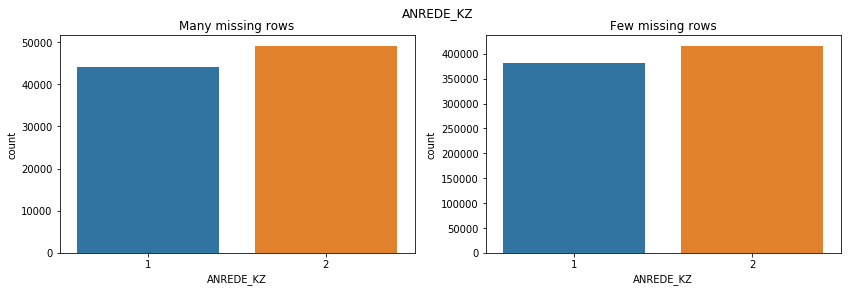

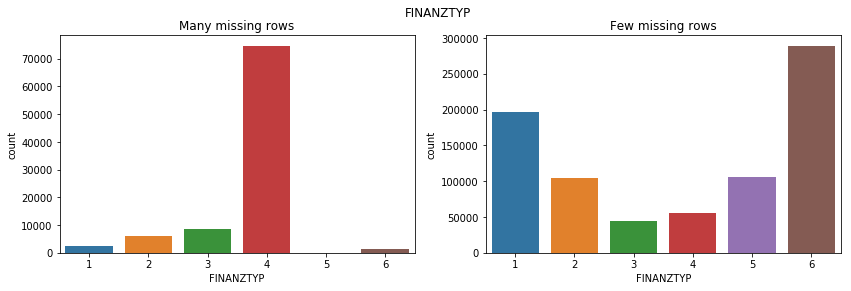

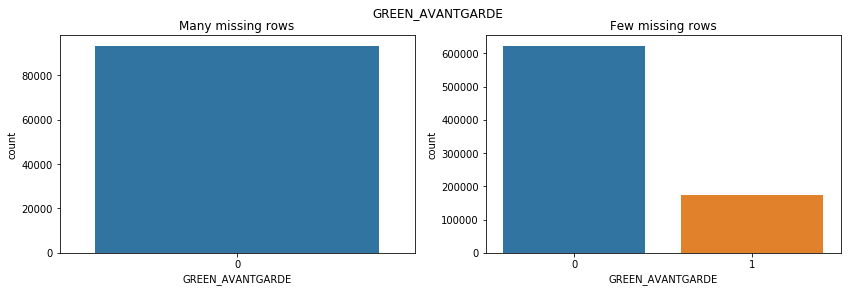

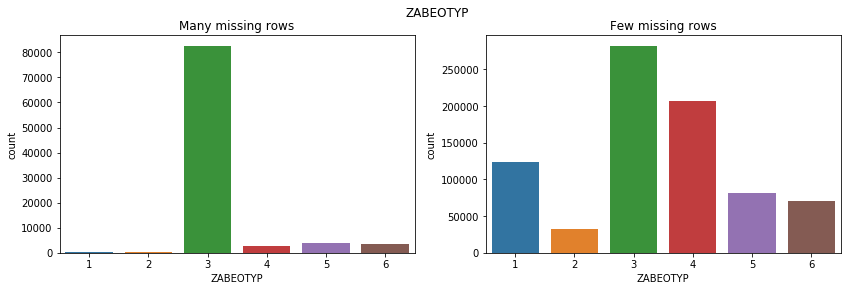

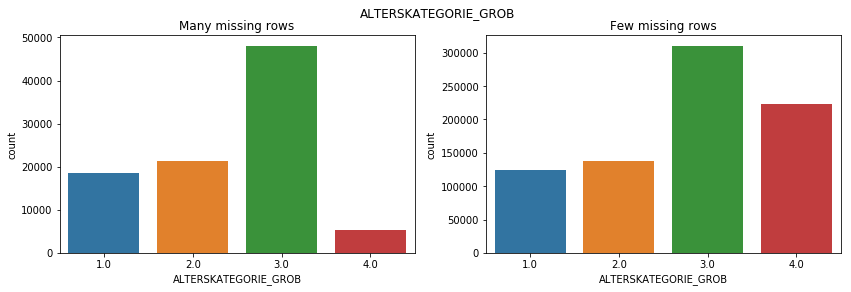

In [32]:
for col in test_columns:
    fig = plt.figure(figsize=(14,4))
    ax1 = fig.add_subplot(121)
    ax1.title.set_text('Many missing rows')
    sns.countplot(azdias.loc[many_missing.index, col ])

    ax2 = fig.add_subplot(122)
    ax2.title.set_text('Few missing rows')
    sns.countplot(azdias.loc[few_missing.index, col])

    fig.suptitle(col)
    plt.show()

In [34]:
compare_std = pd.DataFrame(columns=['Few Missing','Many Missing', 'Difference'] )

In [35]:
for col in test_columns:
    a = few_missing[col].std(axis=0)
    b = many_missing[col].std(axis=0)
    c = abs(a-b)
    compare_std = compare_std.append({'Few Missing' : a , 'Many Missing' : b, 'Difference': c} , ignore_index=True)
compare_std.insert(0, "Test Columns",['ANREDE_KZ', 'FINANZTYP', 'GREEN_AVANTGARDE', 'ZABEOTYP', 'ALTERSKATEGORIE_GROB'] , True)  

In [36]:
compare_std

,Test Columns,Few Missing,Many Missing,Difference
0,ANREDE_KZ,0.499538,0.499255,0.000284
1,FINANZTYP,2.084701,0.754441,1.330260
2,GREEN_AVANTGARDE,0.413950,0.000000,0.413950
3,ZABEOTYP,1.407775,0.711373,0.696402
4,ALTERSKATEGORIE_GROB,1.018408,0.868601,0.149807


#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

#### Answer: ####

To assess the missing values per row, I did the following:
1. I created 2 subsets of Azdias at a 30% missing data cutoff:
    1. **Many Missing** which contains the rows with the most missing data, 
    2. **Few Missing** which contains the rest of the data with few missing data. 
2. I chose 5 columns that have less than 2% missing data
    1. **ANREDE_KZ** [Gender]
    2. **FINANZTYP** [Financial Type]
    3. **GREEN_AVANTGARDE** [Membership in environmental sustainability]
    4. **ZABEOTYP** [Energy consumption]
    5. **ALTERSKATEGORIE_GROB** [Age Group]
3. I used charts and tables to compare the distribution of these columns across both subsets

##### Findings:
From both the charts and the table, I deduced that **ANREDE_KZ**, and **ALTERSKATEGORIE_GROB** had similar distributions across both subsets; however, for **FINANZTYP**, **GREEN_AVANTGARDE**, and **ZABEOTYP** the distribution was quite different. Therefore dropping the rows with many missing values might probably skew clustering. I decided to keep them.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [38]:
#Drop the ones which have been dropped
new_feat = feat_info.set_index('attribute')
new_feat = new_feat.drop(to_be_dropped, axis=0)
new_feat.reset_index();

In [40]:
types = new_feat['type'].value_counts()
types

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [65]:
# Assess categorical variables: which are binary, which are multi-level, and
categorical = new_feat.loc[new_feat['type'] == 'categorical']
categorical = categorical.reset_index()
categorical = pd.DataFrame(columns = categorical['attribute'])
categorical

attribute,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,GEBAEUDETYP,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015


In [99]:
# which one needs to be re-encoded?
for col in categorical:
    print(col)
    test = azdias[col].value_counts()
    number = test.shape[0]
    typ = test.index.dtype
    if number == 2 and typ == 'object':
        #for binary non-numeric
        azdias[col] = azdias[col].map({'W': 1, 'O': 0})
        print("binary numric")
    elif number > 2:
        #For multi-variable
        azdias = pd.get_dummies(azdias, columns=[col])
        print("mul")

ANREDE_KZ
CJT_GESAMTTYP
mul
FINANZTYP
mul
GFK_URLAUBERTYP
mul
GREEN_AVANTGARDE
LP_FAMILIE_FEIN
mul
LP_FAMILIE_GROB
mul
LP_STATUS_FEIN
mul
LP_STATUS_GROB
mul
NATIONALITAET_KZ
mul
SHOPPER_TYP
mul
SOHO_KZ
VERS_TYP
ZABEOTYP
mul
GEBAEUDETYP
mul
OST_WEST_KZ
binary numric
CAMEO_DEUG_2015
mul
CAMEO_DEU_2015
mul


In [103]:
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
0,2.0,1,3,4,3,5,5,3,0,NaN,...,0,0,0,0,0,0,0,0,0,0
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,1,0,0,0,0,0,0,0,0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,0,0,0,0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,0,0,0,0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,0,0,0,0


In [105]:
print("One Hot Encoding increased our columns from 79 to ", azdias.shape[1])

One Hot Encoding increased our columns from 79 to  194


#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

#### Answer:
There are 18 categorical features.
I decided to keep all of them which might not be the most computation-friendly, but I didn't want to risk losing important ones.
For the binary non-numeric, I used a dictionary to replace the two values **W** and **O** with **1** and **0** respectively.
For the multi-level ones, I used getdummies.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [106]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
mixed = new_feat.loc[new_feat['type'] == 'mixed']
mixed.index

Index(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE',
       'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX'],
      dtype='object', name='attribute')

### PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [109]:
azdias['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    188697
8.0     145988
5.0      86416
10.0     85808
3.0      55195
15.0     42547
11.0     35752
9.0      33570
6.0      25652
12.0     24446
1.0      21282
4.0      20451
2.0       7479
13.0      5764
7.0       4010
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [120]:
dict_dec = {1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 3, 7: 3, 8: 4, 9: 4, 10: 5, 11: 5, 12: 5, 13: 5, 14: 6, 15: 6}

In [127]:
azdias['DECADE'] = azdias['PRAEGENDE_JUGENDJAHRE'].map(dict_dec)

In [131]:
movement ={1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1, 12: 0, 13: 1, 14: 0, 15:1}

In [132]:
azdias['MOVEMENT'] = azdias['PRAEGENDE_JUGENDJAHRE'].map(movement)

In [ ]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

### CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [145]:
azdias['CAMEO_INTL_2015'].head(10)

0    NaN
1     51
2     24
3     12
4     43
5     54
6     22
7     14
8     13
9     15
Name: CAMEO_INTL_2015, dtype: object

In [150]:
temp = pd.to_numeric(azdias['CAMEO_INTL_2015'])

In [151]:
temp.head()

0     NaN
1    51.0
2    24.0
3    12.0
4    43.0
Name: CAMEO_INTL_2015, dtype: float64

In [154]:
azdias['WEALTH'] = temp.apply(lambda x: x if pd.isna(x) else int(x/10))

In [156]:
azdias['LIFE_STAGE'] = temp.apply(lambda x: x if pd.isna(x) else int(x%10))

In [157]:
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,2.0,1,3,4,3,5,5,3,0,NaN,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,0,0,6.0,0.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,6.0,1.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,4.0,0.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,4.0,0.0,4.0,3.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [159]:
#Remove the re-engineered mixed columns
azdias = azdias.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis=1)

In [161]:
#Remove the mixed type columns that I didn't re-engineer
azdias = azdias.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'WOHNLAGE', 'PLZ8_BAUMAX'], axis=1)

In [162]:
azdias.shape

(891221, 192)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [3]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    #Load summary file
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')
    
    #parse missing_or_unknown column into list
    missing_unknown = feat_info['missing_or_unknown'].apply(lambda x: x.strip('[]').split(','))
    
    # convert missing value codes into NaNs, ...
    x = 0 
    for col in df:
        if df[col].dtype == 'int64' or df[col].dtype == 'float64':
            if missing_unknown[x] == ['']:
                df.loc[:,col].replace(missing_unknown[x], np.nan, inplace=True)
            else:
                df.loc[:,col].replace(list(map(float, missing_unknown[x])), np.nan, inplace=True)
        else:
            df.loc[:,col].replace(missing_unknown[x], np.nan, inplace=True)
        x += 1
    '''
    # remove selected columns and rows, ...
    #Get columns that are missing more than 20% of data
    percentage = df.isnull().mean() * 100
    to_be_dropped = []
    for i in range(len(percentage)):
        if percentage[i] >= 20:
            to_be_dropped.append(feat_info.loc[i,'attribute'])
            
    #Remove selected columns
    df = df.drop(columns=to_be_dropped)
    '''
    #Hardcode this bit to use it in the customer data..otherwise the percentage is different and the shape is different
    df = df.drop(columns = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'])
    
    #drop from the summary file as well
    new_feat = feat_info.set_index('attribute')
    new_feat = new_feat.drop(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'], axis=0)
    new_feat.reset_index()
    
    # select, re-encode, and engineer column values.
    #Get Categorical columns
    categorical = new_feat.loc[new_feat['type'] == 'categorical']
    categorical = categorical.reset_index()
    categorical = pd.DataFrame(columns = categorical['attribute'])
    
    #Re-encode Categorical
    for col in categorical:
        test = df[col].value_counts()
        number = test.shape[0]
        typ = test.index.dtype
        if number == 2 and typ == 'object':
            #for binary non-numeric
            df[col] = df[col].map({'W': 1, 'O': 0})
        elif number > 2:
            #For multi-variable
            df = pd.get_dummies(df, columns=[col])
            
    #Re-engineer mixed columns
    mixed = new_feat.loc[new_feat['type'] == 'mixed']
    
    #RAEGENDE_JUGENDJAHRE column
    dict_dec = {1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 3, 7: 3, 8: 4, 9: 4, 10: 5, 11: 5, 12: 5, 13: 5, 14: 6, 15: 6}
    df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].map(dict_dec)
    movement ={1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1, 12: 0, 13: 1, 14: 0, 15:1}
    df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].map(movement)
    
    #CAMEO_INTL_2015 column
    temp = pd.to_numeric(df['CAMEO_INTL_2015'])
    df['WEALTH'] = temp.apply(lambda x: x if pd.isna(x) else int(x/10))
    df['LIFE_STAGE'] = temp.apply(lambda x: x if pd.isna(x) else int(x%10))
            
    #Drop re-engineered and non-engineered mixed type columns
    df = df.drop(mixed.index, axis=1)
    
    #Copy to new df
    df_clean = df
    
    # Return the cleaned dataframe.
    return df_clean
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [4]:
#starting point for when I log out
azdias = clean_data(azdias)
azdias.shape

(891221, 192)

In [27]:
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,2.0,1,3,4,3,5,5,3,0,NaN,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,0,0,6.0,0.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,6.0,1.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,4.0,0.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,4.0,0.0,4.0,3.0


In [5]:
headers = azdias.columns

In [6]:
azdias.isna().sum().sum()

4154590

In [6]:
from sklearn.preprocessing import Imputer, StandardScaler

In [7]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
Imp = Imputer(strategy='most_frequent')
azdias_imputed = pd.DataFrame(Imp.fit_transform(azdias))

In [8]:
azdias_imputed.isna().sum().sum()

0

In [9]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias_imputed))

In [11]:
azdias_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,182,183,184,185,186,187,188,189,190,191
0,-0.751680,-1.045218,-0.056416,0.804890,-0.303378,1.285741,1.429871,-0.055511,-0.494701,0.938197,...,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,-0.084907,0.994991,-0.494701,1.039938,-1.095866
1,-1.743339,0.956738,-1.570358,1.487601,-1.059731,1.285741,0.757254,1.422415,-0.494701,0.938197,...,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,-0.084907,0.994991,-0.494701,1.039938,-1.095866
2,0.239980,0.956738,-1.570358,0.804890,-1.816084,-0.675554,0.084637,1.422415,2.021423,0.938197,...,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,-0.084907,0.994991,2.021423,-0.980453,0.879581
3,1.231640,0.956738,0.700556,-0.560532,1.209329,-0.675554,-1.260597,-0.794475,-0.494701,-0.385397,...,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,-0.084907,-0.363493,-0.494701,-1.653917,-0.437384
4,0.239980,-1.045218,0.700556,0.122179,0.452976,-1.329319,0.084637,-0.794475,-0.494701,0.938197,...,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,-0.084907,-0.363493,-0.494701,0.366474,0.221098


In [10]:
azdias_scaled.columns = headers

In [11]:
azdias_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,-0.751680,-1.045218,-0.056416,0.804890,-0.303378,1.285741,1.429871,-0.055511,-0.494701,0.938197,...,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,-0.084907,0.994991,-0.494701,1.039938,-1.095866
1,-1.743339,0.956738,-1.570358,1.487601,-1.059731,1.285741,0.757254,1.422415,-0.494701,0.938197,...,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,-0.084907,0.994991,-0.494701,1.039938,-1.095866
2,0.239980,0.956738,-1.570358,0.804890,-1.816084,-0.675554,0.084637,1.422415,2.021423,0.938197,...,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,-0.084907,0.994991,2.021423,-0.980453,0.879581
3,1.231640,0.956738,0.700556,-0.560532,1.209329,-0.675554,-1.260597,-0.794475,-0.494701,-0.385397,...,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,-0.084907,-0.363493,-0.494701,-1.653917,-0.437384
4,0.239980,-1.045218,0.700556,0.122179,0.452976,-1.329319,0.084637,-0.794475,-0.494701,0.938197,...,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,-0.084907,-0.363493,-0.494701,0.366474,0.221098


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

#### Answer:
I used Imputer to transform all NaN values to the most frequently occuring ones per column. **Most Frequent** was chosen instead of the default **mean** to account for any anomalies in normal distribution of columns.
Then to achieve a standard deviation from 0 to 1, the data was scaled using StandardScaler. 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [12]:
from sklearn.decomposition import PCA

In [17]:
# Apply PCA to the data.
pca = PCA()
pca.fit_transform(azdias_scaled) 

array([[  2.61205218e+00,  -9.78276460e-01,  -3.88422513e+00, ...,
          1.99440484e-14,  -7.32154334e-15,  -2.80664093e-15],
       [  5.11047028e+00,  -3.21230473e+00,  -3.82999119e-01, ...,
          3.26775613e-14,   3.40209929e-14,   2.50984552e-15],
       [ -6.65287222e-01,  -5.00037765e-01,  -1.30015947e+00, ...,
         -9.31722855e-16,  -4.82302312e-15,  -6.45821042e-16],
       ..., 
       [ -7.62894678e-01,  -3.78552778e+00,  -7.99216333e-01, ...,
          9.44413124e-17,   1.44850147e-17,   3.33691998e-18],
       [  6.24383682e+00,  -3.07528043e+00,   4.44828527e+00, ...,
         -6.79461531e-17,  -9.61393951e-17,  -5.00865729e-18],
       [ -3.89318563e-03,   3.18541336e+00,   2.18511956e+00, ...,
          5.10343570e-17,  -7.22813559e-18,  -1.37573890e-19]])

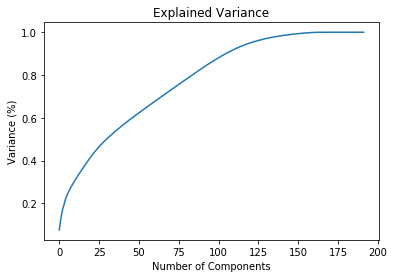

In [18]:
# Investigate the variance accounted for by each principal component.
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Explained Variance')
plt.show()

In [13]:
# Re-apply PCA to the data while selecting for number of components to retain.
#Looks like 80% variance is explained by 75 components.
pca_final = PCA(75)

In [14]:
X_pca = pca_final.fit_transform(azdias_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

### Answer:
From the variance graph, it looks like 80% of the data is explained by the first 75 components; hence the PCA was recalculated to use 75 principle components. This effectively reduces the feature dimensionality from 192 features to 75 which cuts it by more than half. This will result in a more robust model.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [39]:
def pca_results(df, pca, component_no):
    
    # Build a dataframe with features_no features capturing most variability
    # for a given component number (component_no)
    pca_comp = pd.DataFrame(np.round(pca.components_, 4), columns=df.keys()).iloc[component_no - 1]
    pca_comp.sort_values(ascending=False, inplace=True)
    pca_comp = pd.concat([pca_comp.head(5), pca_comp.tail(5)])
    
    pca_comp.plot(kind='bar', 
                  title='Most {} weighted features for PCA component {}'.format(5*2, component_no+1),
                  figsize=(12, 6))
    plt.show()
    
    return pca_comp

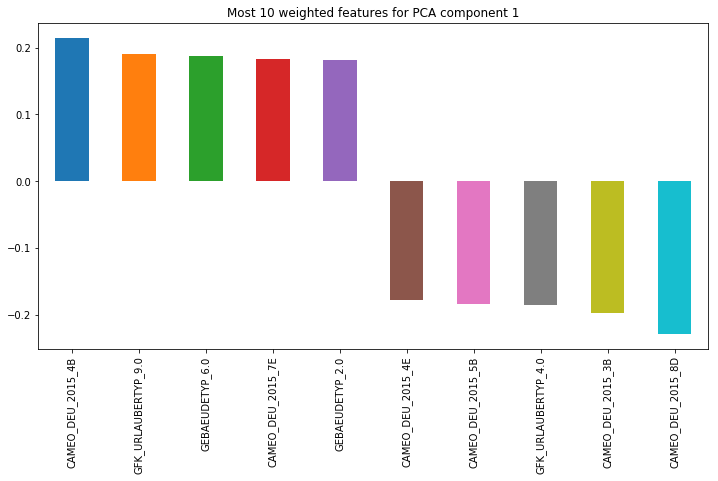

CAMEO_DEU_2015_4B      0.2153
GFK_URLAUBERTYP_9.0    0.1900
GEBAEUDETYP_6.0        0.1878
CAMEO_DEU_2015_7E      0.1834
GEBAEUDETYP_2.0        0.1820
CAMEO_DEU_2015_4E     -0.1775
CAMEO_DEU_2015_5B     -0.1836
GFK_URLAUBERTYP_4.0   -0.1851
CAMEO_DEU_2015_3B     -0.1973
CAMEO_DEU_2015_8D     -0.2293
Name: 74, dtype: float64


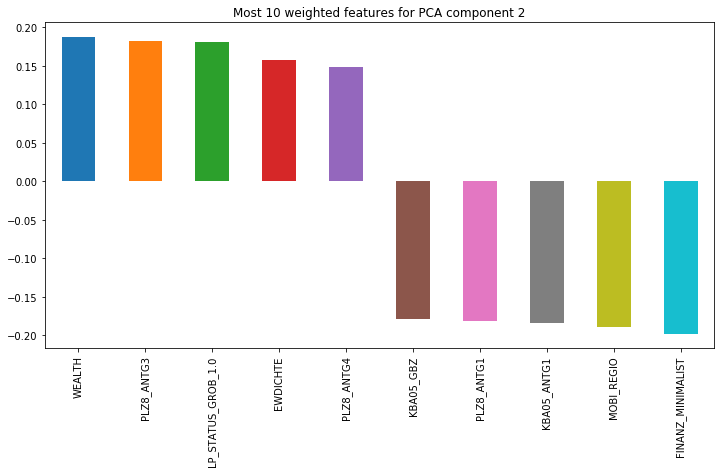

WEALTH                0.1873
PLZ8_ANTG3            0.1826
LP_STATUS_GROB_1.0    0.1805
EWDICHTE              0.1572
PLZ8_ANTG4            0.1480
KBA05_GBZ            -0.1788
PLZ8_ANTG1           -0.1821
KBA05_ANTG1          -0.1843
MOBI_REGIO           -0.1898
FINANZ_MINIMALIST    -0.1981
Name: 0, dtype: float64


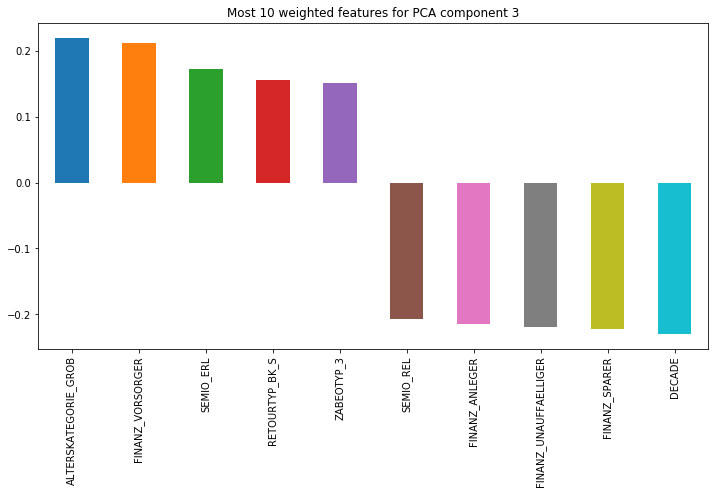

ALTERSKATEGORIE_GROB     0.2203
FINANZ_VORSORGER         0.2117
SEMIO_ERL                0.1723
RETOURTYP_BK_S           0.1562
ZABEOTYP_3               0.1507
SEMIO_REL               -0.2075
FINANZ_ANLEGER          -0.2141
FINANZ_UNAUFFAELLIGER   -0.2195
FINANZ_SPARER           -0.2217
DECADE                  -0.2302
Name: 1, dtype: float64


In [26]:
for i in np.arange(0, 3, 1):
    res = pca_results(azdias_scaled, pca_final, i)
    print(res)

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

### Answer:

1. First component:

| Feature  | Dictionary   |Weight   |
|------|------|------|
| CAMEO_DEU_2015_4B  | Life Stage Typology: Family life   |0.2153   |
| GFK_URLAUBERTYP_9.0   | Vacation habits: Package tour travelers|0.1900|
| GEBAEUDETYP_6.0   | Type of building: mixed building without actually known household|0.1878|
| CAMEO_DEU_2015_7E   | Life Stage Typology: Interested Retirees|0.1834|
| GEBAEUDETYP_2.0    | Type of building: residential building buildings without actually known household|0.1820|
| CAMEO_DEU_2015_4E    | Life Stage Typology: Golden Ager|-0.1775|
| CAMEO_DEU_2015_5B    | Life Stage Typology: Suddenly Family|-0.1836|
| GFK_URLAUBERTYP_4.0  | Vacation habits: Culture lovers|-0.1851|
| CAMEO_DEU_2015_3B    | Life Stage Typology: Powershopping Families|-0.1973|
| CAMEO_DEU_2015_8D    | Life Stage Typology: Town Seniors|-0.2293|

It appears that this component correlates life stage with vacation habits as well as type of building.

2. Second Component:

| Feature  | Dictionary   |Weight   |
|------|------|------|
| WEALTH | Wealth   |0.1873  |
| PLZ8_ANTG3  | Number of 6-10 family houses|0.1826|
| LP_STATUS_GROB_1.0 | Social status: low-income earners|0.1805|
| EWDICHTE    | Density of households per square kilometer|0.1572|
| PLZ8_ANTG4    | Number of 10+ family houses|0.1480|
| KBA05_GBZ     | Number of buildings in the microcell|-0.1788|
| PLZ8_ANTG1 | Number of 1-2 family houses|-0.1821|
| KBA05_ANTG1 | Number of 1-2 family houses|-0.1843|
| MOBI_REGIO    | Movement patterns| -0.1898|
| FINANZ_MINIMALIST   | low financial interest|   -0.1981|

It appears that this component correlates between wealth and the neighborhood type.

3. Third Component:

| Feature  | Dictionary   |Weight   |
|------|------|------|
| ALTERSKATEGORIE_GROB | Estimated age   |0.2203  |
| FINANZ_VORSORGER  | Financially prepared|0.2117|
| SEMIO_ERL | event-oriented| 0.1723|
| RETOURTYP_BK_S   | Return type|0.1562|
| ZABEOTYP_3     | Energy consumption: fair supplied|0.1507|
| SEMIO_REL     | religious|-0.2075|
| FINANZ_ANLEGER  | Investor|-0.2141|
| FINANZ_UNAUFFAELLIGER | inconspicuous|-0.2195|
| FINANZ_SPARER    | money-saver|-0.2217|
| DECADE   | Decade|   -0.2302|

It appears that this component correlates between age and financial astuteness.


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [159]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

In [161]:
scores = []
centers = list(range(1,30))

for center in centers:
    scores.append(get_kmeans_score(X_pca, center))
    print('Fitted Kmeans to {} centers'.format(center))

Fitted Kmeans to 1 centers
Fitted Kmeans to 2 centers
Fitted Kmeans to 3 centers
Fitted Kmeans to 4 centers
Fitted Kmeans to 5 centers
Fitted Kmeans to 6 centers
Fitted Kmeans to 7 centers
Fitted Kmeans to 8 centers
Fitted Kmeans to 9 centers
Fitted Kmeans to 10 centers
Fitted Kmeans to 11 centers
Fitted Kmeans to 12 centers
Fitted Kmeans to 13 centers
Fitted Kmeans to 14 centers
Fitted Kmeans to 15 centers
Fitted Kmeans to 16 centers
Fitted Kmeans to 17 centers
Fitted Kmeans to 18 centers
Fitted Kmeans to 19 centers
Fitted Kmeans to 20 centers
Fitted Kmeans to 21 centers
Fitted Kmeans to 22 centers
Fitted Kmeans to 23 centers
Fitted Kmeans to 24 centers
Fitted Kmeans to 25 centers
Fitted Kmeans to 26 centers
Fitted Kmeans to 27 centers
Fitted Kmeans to 28 centers
Fitted Kmeans to 29 centers


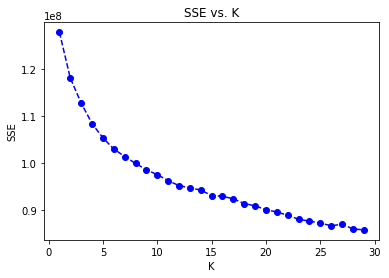

In [162]:
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');  

In [15]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=24)
model_azdias = kmeans.fit(X_pca)

In [32]:
predict_azdias = model_azdias.predict(X_pca)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

### Answer:
The plot doesn't show a distinct elbow; however, you notice that the SSE saturates around 20 clusters. That's why I chose 24 clusters. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [16]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [17]:
customers.shape

(191652, 85)

In [18]:
customer_clean = clean_data(customers)

In [19]:
customer_clean.shape

(191652, 191)

There seems to be a missing column, since Azdias has 192 columns

In [20]:
#Check which column is missing from the customer data
missing = []
for col in azdias:
    if col in customer_clean.columns:
        pass
    else:
        missing.append(col)

In [144]:
missing

['GEBAEUDETYP_5.0']

Looks like the 5th type of building didn't exist in the customer data; hence the one-hot encoding didn't create a column for it. Let's manually add a zero column then.

In [21]:
azdias_scaled.columns.get_loc('GEBAEUDETYP_5.0')

132

In [22]:
customer_clean.insert(132, 'GEBAEUDETYP_5.0', 0)

In [23]:
#Now the shape is right
customer_clean.shape

(191652, 192)

In [24]:
cust_head = customer_clean.columns

In [25]:
#Remove NaNs
customers_imputed = pd.DataFrame(Imp.transform(customer_clean))

In [26]:
customers_imputed.isna().sum().sum()

0

In [27]:
#Apply Standardscaler
customers_scaled = pd.DataFrame(scaler.transform(customers_imputed))

In [156]:
customers_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,182,183,184,185,186,187,188,189,190,191
0,1.23164,-1.045218,1.457527,-1.243244,1.209329,-1.329319,-0.587980,-0.794475,2.021423,-1.708990,...,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,23.640094,-2.401220,2.021423,-0.306989,-1.754349
1,1.23164,-1.045218,1.457527,-1.243244,1.209329,-1.329319,0.084637,-0.794475,-0.494701,-1.708990,...,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,-0.084907,0.994991,-0.494701,1.039938,-1.754349
2,1.23164,0.956738,1.457527,-1.243244,1.209329,-1.329319,0.757254,0.683452,2.021423,-0.385397,...,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,23.640094,-2.401220,7.053672,0.366474,-1.754349
3,1.23164,-1.045218,1.457527,-1.243244,1.209329,-0.675554,-1.260597,-0.794475,-0.494701,-0.385397,...,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,11.777594,-3.080462,4.537548,0.366474,-1.754349
4,0.23998,-1.045218,-0.056416,-1.243244,0.452976,0.631976,1.429871,-0.794475,-0.494701,0.938197,...,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,47.365095,-3.080462,9.569796,-1.653917,-1.754349


In [28]:
customers_scaled.columns = cust_head
customers_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,1.23164,-1.045218,1.457527,-1.243244,1.209329,-1.329319,-0.587980,-0.794475,2.021423,-1.708990,...,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,-0.084907,-1.721978,2.021423,-1.653917,0.221098
1,1.23164,-1.045218,1.457527,-1.243244,1.209329,-1.329319,0.084637,-0.794475,-0.494701,-1.708990,...,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,-0.084907,0.994991,-0.494701,1.039938,-1.095866
2,1.23164,0.956738,1.457527,-1.243244,1.209329,-1.329319,0.757254,0.683452,2.021423,-0.385397,...,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,-0.084907,-1.721978,2.021423,-0.306989,0.879581
3,1.23164,-1.045218,1.457527,-1.243244,1.209329,-0.675554,-1.260597,-0.794475,-0.494701,-0.385397,...,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,-0.084907,-2.401220,-0.494701,-0.980453,0.879581
4,0.23998,-1.045218,-0.056416,-1.243244,0.452976,0.631976,1.429871,-0.794475,-0.494701,0.938197,...,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,-0.084907,-0.363493,-0.494701,0.366474,-1.095866


In [29]:
# PCA
Y_pca = pca_final.transform(customers_scaled)

In [30]:
#KMeans
predict_customers = model_azdias.predict(Y_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

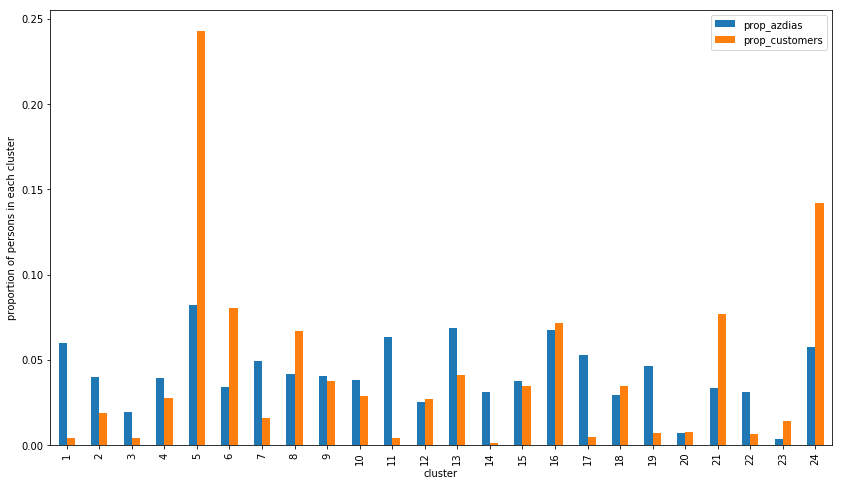

In [33]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
azdias_prop = []
customers_prop = []
x = [i+1 for i in range(24)]
for i in range(24):
    azdias_prop.append((predict_azdias == i).sum()/len(predict_azdias))
    customers_prop.append((predict_customers == i).sum()/len(predict_customers))


df_general = pd.DataFrame({'cluster' : x, 'prop_azdias' : azdias_prop, 'prop_customers':customers_prop})

#ax = sns.countplot(x='index', y = df_general['prop_1', 'prop_2'], data=df_general )
df_general.plot(x='cluster', y = ['prop_azdias', 'prop_customers'], kind='bar', figsize=(14,8))
plt.ylabel('proportion of persons in each cluster')
plt.show()

Over represented:
- cluster 5, 6, 24

Under represented:
- cluster 1, 11, 17, 19

In [88]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
# This is for cluster 6
over = pd.DataFrame(pca_final.inverse_transform(Y_pca[np.where(predict_customers==5)]), columns= customers_scaled.columns)


In [35]:
over.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,2.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,0.0,2.0,-1.0,...,-1.0,-1.0,-1.0,0.0,-0.0,-0.0,-1.0,2.0,-2.0,0.0
1,1.0,-1.0,2.0,-1.0,1.0,-2.0,-1.0,-0.0,2.0,-1.0,...,-0.0,-0.0,-0.0,-1.0,0.0,0.0,-1.0,2.0,-1.0,1.0
2,0.0,-1.0,1.0,-1.0,1.0,-1.0,-0.0,-1.0,3.0,0.0,...,-0.0,-1.0,0.0,-0.0,0.0,0.0,-0.0,3.0,-1.0,1.0
3,0.0,-1.0,1.0,-1.0,1.0,-1.0,-0.0,-1.0,3.0,-1.0,...,0.0,-0.0,0.0,-1.0,0.0,0.0,-1.0,3.0,-2.0,2.0
4,1.0,-1.0,2.0,-1.0,1.0,-2.0,-1.0,-1.0,2.0,-1.0,...,-0.0,-0.0,0.0,-1.0,0.0,0.0,-1.0,2.0,-2.0,2.0


In [36]:
over.shape

(15403, 192)

In [89]:
def important(df):
    
    #Since the values are scaled, the mean of each column will help use determine the highest and lowest columns
    averages = df.mean()
    averages = pd.DataFrame(averages.sort_values(ascending=False))
    new = pd.concat([averages.head(5), averages.tail(5)]).T
    
    new.plot(kind='bar', 
                  title='Most important features for this cluster',
                  figsize=(12, 6))
    plt.show()
    
    return new

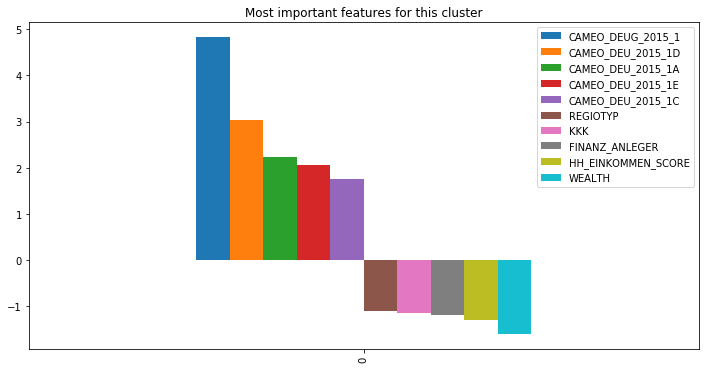

In [90]:
important1 = important(over)

In [77]:
#Examine the actual values for these features
over1Actual = pd.DataFrame(scaler.inverse_transform(over).round(), columns = customers_scaled.columns)



In [78]:
def values(df, important):
    for col in important:
        print(df[col].value_counts())
    

In [79]:
values(over1Actual, important1)

1.0    15403
Name: CAMEO_DEUG_2015_1, dtype: int64
0.0    9697
1.0    5706
Name: CAMEO_DEU_2015_1D, dtype: int64
0.0    11642
1.0     3761
Name: CAMEO_DEU_2015_1A, dtype: int64
0.0    13983
1.0     1420
Name: CAMEO_DEU_2015_1E, dtype: int64
-0.0    13539
 1.0     1864
Name: CAMEO_DEU_2015_1C, dtype: int64
2.0    4377
1.0    3524
3.0    2769
5.0    2365
4.0    1374
6.0     829
0.0     124
7.0      41
Name: REGIOTYP, dtype: int64
1.0    6945
2.0    4497
3.0    3274
0.0     389
4.0     298
Name: KKK, dtype: int64
 1.0    7819
 2.0    3461
 0.0    2936
 3.0     965
 4.0     191
 5.0      26
-1.0       5
Name: FINANZ_ANLEGER, dtype: int64
2.0    8186
1.0    3298
3.0    2604
4.0    1072
5.0     223
0.0      13
6.0       7
Name: HH_EINKOMMEN_SCORE, dtype: int64
1.0    10046
2.0     3299
0.0     2055
3.0        3
Name: WEALTH, dtype: int64


## Overrepresented Segment 1:
### This segment groups together high-income earners and wealthy individuals who have a high purchasing power
- German CAMEO: Wealth / Life Stage Typology
    - Upper Class
- Neighborhood typology
    - upper class
    - conservatives
    - upper middle class
- Purchasing power in region
    - very high
    - high
    - average
- Financial Topology (investor)
    - very high
    - high
    - average
- Estimated household net income
    - highest income
    - very high income
- Wealth
    - wealthy
    - prosperous
    - comfortable

In [105]:
over2 = pd.DataFrame(pca_final.inverse_transform(Y_pca[np.where(predict_customers==4)]), columns= customers_scaled.columns)


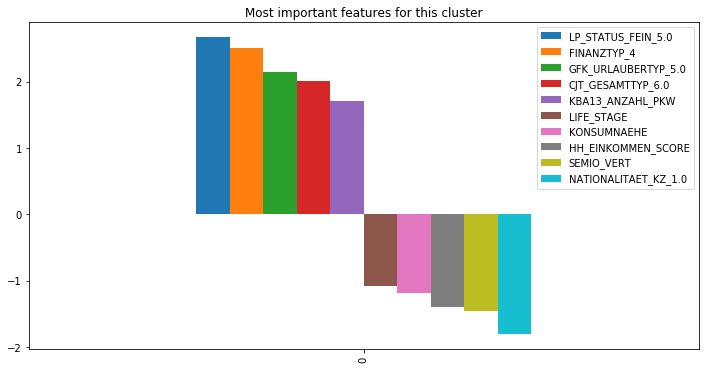

In [106]:
over2feat = important(over2)

In [107]:
over2Actual = pd.DataFrame(scaler.inverse_transform(over).round(), columns = customers_scaled.columns)

In [108]:
values(over2Actual, over2feat)

-0.0    15361
 1.0       42
Name: LP_STATUS_FEIN_5.0, dtype: int64
0.0    15385
1.0       18
Name: FINANZTYP_4, dtype: int64
-0.0    15127
 1.0      276
Name: GFK_URLAUBERTYP_5.0, dtype: int64
-0.0    14970
 1.0      432
-1.0        1
Name: CJT_GESAMTTYP_6.0, dtype: int64
 510.0     35
 534.0     34
 432.0     33
 461.0     32
 467.0     32
 459.0     31
 479.0     31
 489.0     30
 491.0     30
 599.0     30
 393.0     29
 496.0     29
 472.0     29
 414.0     29
 559.0     29
 639.0     29
 398.0     28
 511.0     28
 629.0     28
 477.0     28
 506.0     28
 464.0     28
 400.0     27
 505.0     27
 455.0     27
 552.0     27
 530.0     27
 504.0     27
 626.0     27
 509.0     27
           ..
-322.0      1
 1340.0     1
 1539.0     1
 1412.0     1
 1405.0     1
-239.0      1
 1351.0     1
 175.0      1
-151.0      1
-89.0       1
 152.0      1
 1384.0     1
 1489.0     1
 1349.0     1
 187.0      1
-149.0      1
 1399.0     1
 1353.0     1
 36.0       1
 1491.0     1
 1444.0     1

## Overrepresented Segment 2:
### High income German families and elders who are consumers and enjoy advertising
- high- highest family income
- Not nature fans nor minimalist
- Nationality based on given name analysis is German
- High number of cars in the neigborhood
- Advertising-Enthusiast with restricted Cross-Channel-Behaviour
- Families With School Age Children and Elders In Retirement

In [91]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
under = pd.DataFrame(pca_final.inverse_transform(X_pca[np.where(predict_azdias==1)]), columns= customers_scaled.columns)


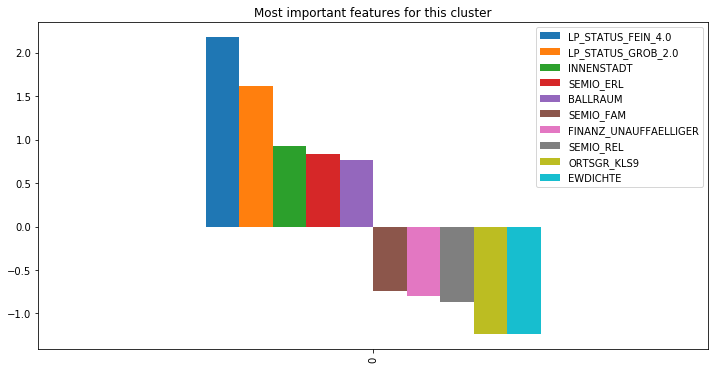

In [92]:
important2 = important(under)

In [93]:
under1Actual = pd.DataFrame(scaler.inverse_transform(under).round(), columns = customers_scaled.columns)


In [94]:
values(under1Actual, important2)

1.0    32989
0.0     2764
Name: LP_STATUS_FEIN_4.0, dtype: int64
 1.0    34983
-0.0      770
Name: LP_STATUS_GROB_2.0, dtype: int64
7.0    14355
6.0    13932
5.0     4456
8.0     2452
4.0      529
9.0       20
3.0        9
Name: INNENSTADT, dtype: int64
6.0    12526
7.0    12375
4.0     4788
5.0     4137
8.0     1248
3.0      667
2.0       10
1.0        2
Name: SEMIO_ERL, dtype: int64
6.0     14168
7.0      9513
5.0      7622
4.0      2373
8.0      1637
3.0       368
9.0        57
2.0        14
10.0        1
Name: BALLRAUM, dtype: int64
2.0    17732
3.0     6329
5.0     5225
4.0     4100
1.0     1903
6.0      446
7.0       18
Name: SEMIO_FAM, dtype: int64
2.0    16138
1.0    14083
3.0     3593
0.0      998
4.0      925
5.0       16
Name: FINANZ_UNAUFFAELLIGER, dtype: int64
2.0    12233
3.0    10418
1.0     6370
4.0     5246
5.0     1124
6.0      208
0.0      151
7.0        3
Name: SEMIO_REL, dtype: int64
2.0    12801
3.0    11904
4.0     5414
1.0     4427
5.0      876
0.0      248
6.0 

## Underrepresented Segment 1:
### This segment groups together villagers and minimilistic high-income earners who live far away from the city center and are more family and religious inclined. 
- Social Status, fine scale
    - Villagers
- Social Status, rough scale
    - average earners; maps to:
        - aspiring low-income earners
        - villagers
        - minimalistic high-income earners
- Distance to city center
    - 20 - 30 km to city center
    - 30 - 40 km to city center
- Distance to nearest urban center
    - 50 - 100 km
    - more than 100 km
- Personality typology [Family-minded]
    - very high affinity
    - high affinity
- Personality typology [Religious]
    - highest affinity
    - very high affinity
    - high affinity
- Size of community
    - <= 2,000 inhabitants
    - 2,001 to   5,000 inhabitants
    - 5,001 to  10,000 inhabitants
- Density of households per square kilometer
    - less than 34 households per km^2
    - 34 -  89 households per km^2
    - 90 - 149 households per km^2

In [109]:
under2 = pd.DataFrame(pca_final.inverse_transform(X_pca[np.where(predict_azdias==0)]), columns= customers_scaled.columns)


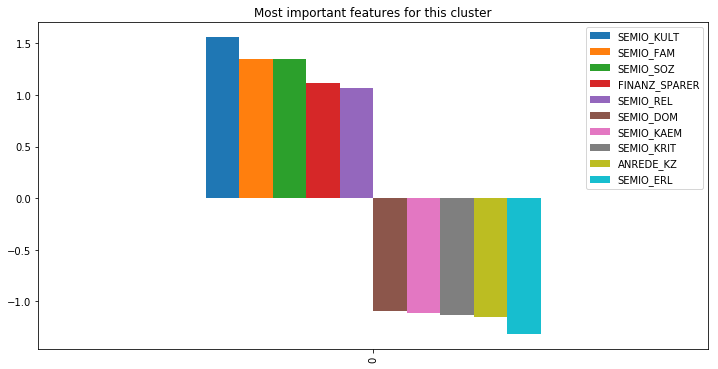

In [110]:
important22 = important(under2)

In [111]:
under2Actual = pd.DataFrame(scaler.inverse_transform(under2).round(), columns = customers_scaled.columns)


In [112]:
values(under2Actual, important22)

7.0    31126
8.0    13347
6.0     4495
5.0     4053
4.0      305
9.0        5
Name: SEMIO_KULT, dtype: int64
7.0    37437
6.0     7597
8.0     5147
5.0     3101
4.0       44
9.0        5
Name: SEMIO_FAM, dtype: int64
7.0    30013
6.0    17772
5.0     3245
8.0     2113
4.0      187
9.0        1
Name: SEMIO_SOZ, dtype: int64
5.0    27859
4.0    20134
3.0     3639
2.0      907
6.0      778
1.0       14
Name: FINANZ_SPARER, dtype: int64
7.0    23290
6.0    19939
5.0     3779
8.0     3304
4.0     2853
3.0      163
9.0        2
2.0        1
Name: SEMIO_REL, dtype: int64
3.0    24652
2.0    22216
4.0     6063
1.0      284
5.0      116
Name: SEMIO_DOM, dtype: int64
2.0    29178
3.0    18887
1.0     3190
4.0     2068
5.0        7
0.0        1
Name: SEMIO_KAEM, dtype: int64
 3.0    20922
 2.0    19431
 4.0     8773
 1.0     3353
 5.0      792
-0.0       60
Name: SEMIO_KRIT, dtype: int64
1.0    53325
2.0        4
0.0        2
Name: ANREDE_KZ, dtype: int64
2.0    19847
1.0    15468
3.0    13276
4.

## Underrepresented Segment 2:
### This segment is an all male one, typically those who don't value family or social life. They're most likely to be former or current soldiers.
- lowest affinity to culture, religion, family, and social life.
- very high affinity to be dominant, combative, and critical minded.
- ~100% Male

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

### Answer:

- The mail-order company is very popular with overall wealthy individuals as well as more mature and traditional consumer-oriented German families.
- The mail-order company is not popular with villagers and people who live far from the city center as well as single current or former soldiers.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.